In [1]:
import os
import re
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

import gvar as gv
import lsqfit

In [2]:
DATA = "/Users/ckoerber/data/nuc/dens"
files = os.listdir(DATA)

In [3]:
files[0]

'compton-dens-4he-av18-empot-urbix-Lamnum=1.000e+08-tnfcut=3-om=8.00E+00-th=1.80E+02-nx=16-nphi=16-np12=np34=28+8-np3=36+8-nq4=nq=36+6-j12max=5-lmax=6-lsummax=14-tau4max=0-rho1b.dat'

In [4]:
patterns = (
    r"compton-dens-(?P<nuc>[0-9A-z]+)",
    r"(?P<potential>[a-z0-9]+)",
    r"(?:(?P<empot>(?:empot)))?",
    r"(?:(?P<tnf>(?:[a-z]+)))?",
    r"(?:Lamnum=(?P<lambda>(?:[0-9\.e\+]+)))?",
    r"(?:tnfcut=(?P<tnfcut>(?:[0-9]+)))?",
    r"om=(?P<omega>(?:[0-9\.]+E[\+\-][0-9]+))",
    r"th=(?P<theta>(?:[0-9\.E\+]+))",
    r"nx=(?P<nx>(?:[0-9]+))",
    r"nphi=(?P<nphi>(?:[0-9]+))",
    r"np12\=np34\=(?P<np12_np34>(?:[0-9\+]+))",
    r"np3\=(?P<np3>(?:[0-9\+]+))",
    r"nq4\=nq=(?P<nq4_nq>(?:[0-9\+]+))",
    r"j12max=(?P<j12max>(?:[0-9]+))",
    r"lmax=(?P<lmax>(?:[0-9]+))",
    r"lsummax=(?P<lsummax>(?:[0-9]+))",
    r"tau4max=(?P<tau4max>(?:[0-9]+))",
    r"rho1b\.dat",
)
pattern = re.compile("-".join(patterns))
pattern.search(files[0]).groupdict()

{'nuc': '4he',
 'potential': 'av18',
 'empot': 'empot',
 'tnf': 'urbix',
 'lambda': '1.000e+08',
 'tnfcut': '3',
 'omega': '8.00E+00',
 'theta': '1.80E+02',
 'nx': '16',
 'nphi': '16',
 'np12_np34': '28+8',
 'np3': '36+8',
 'nq4_nq': '36+6',
 'j12max': '5',
 'lmax': '6',
 'lsummax': '14',
 'tau4max': '0'}

In [5]:
dtypes = {
    int: ["tnfcut", "nx", "nphi", "j12max", "lmax", "lsummax", "tau4max"],
    float: ["lambda", "omega", "theta"],
}

In [6]:
data = [pattern.search(f).groupdict() for f in files]
df = pd.DataFrame(data)
for dtype, cols in dtypes.items():
    for col in cols:
        df[col] = df[col].astype(dtype)

df["file"] = files
df.head()

,nuc,potential,empot,tnf,lambda,tnfcut,omega,theta,nx,nphi,np12_np34,np3,nq4_nq,j12max,lmax,lsummax,tau4max,file
0,4he,av18,empot,urbix,100000000.0,3,8.0,180.0,16,16,28+8,36+8,36+6,5,6,14,0,compton-dens-4he-av18-empot-urbix-Lamnum=1.000...
1,4he,av18,empot,urbix,100000000.0,3,80.0,90.0,16,16,28+8,36+8,36+6,5,6,14,0,compton-dens-4he-av18-empot-urbix-Lamnum=1.000...
2,4he,av18,empot,urbix,100000000.0,3,140.0,180.0,16,16,28+8,36+8,36+6,5,6,14,0,compton-dens-4he-av18-empot-urbix-Lamnum=1.000...
3,4he,av18,empot,urbix,100000000.0,3,3.0,180.0,16,16,28+8,36+8,36+6,5,6,14,0,compton-dens-4he-av18-empot-urbix-Lamnum=1.000...
4,4he,av18,empot,urbix,100000000.0,3,400.0,180.0,16,16,28+8,36+8,36+6,5,6,14,0,compton-dens-4he-av18-empot-urbix-Lamnum=1.000...


Only varying quantities are omega and theta

In [7]:
pp = r"MAXRHO1BINDEX\s+\=\s+(?P<max_rho_index>[0-9]+)"
pp += r".*"
pp += r"RHO1BINDX\s+\=(?P<rho_index>[0-9\*\,\-\s]+)"
pp += r".*"
pp += r"\/\s+(?P<om_theta>[0-9\.\-\+E ]+\n)"
pp += r"\s+(?P<rho>[0-9\.\-\+E\s]+\n)"


def parse_fortran_funny(string):
    for pat, subs in {
        f"{key}*{val}": ", ".join([val] * int(key))
        for key, val in set(
            re.findall(r"([0-9]+)\*([\-0-9]+)", re.sub(r"\s+", " ", string))
        )
    }.items():
        string = string.replace(pat, subs)

    arr = np.array(list(map(int, string.split(","))))
    nd = len(arr) // 8
    return pd.DataFrame(
        data=arr.reshape([nd, 8]),
        columns=[
            "ms3_x2",
            "mt3_x2",
            "mjtot_x2",
            "ms3p_x2",
            "mt3p_x2",
            "mjtotp_x2",
            "k",
            "bk",
        ],
    )


parse = {
    "max_rho_index": int,
    "om_theta": lambda el: np.array([float(ee) for ee in el.split(" ") if ee]),
    "rho": lambda el: np.array([float(ee) for ee in el.split(" ") if ee]),
    "rho_index": parse_fortran_funny,
}


def parse_1bd(address):
    with open(address, "r") as inp:
        t = inp.read()
    dd = re.search(pp, t, re.MULTILINE | re.DOTALL).groupdict()
    for key, val in parse.items():
        dd[key] = val(dd[key])
    return dd

In [8]:
f = df.query("omega == 0").file.values[0]
dens = parse_1bd(os.path.join(DATA, f))

k and bk encode angular dependence of the one-body operator
$$
O_{1} ( \vec k_{1} \  \mu' \mu \   \nu  \  \vec k ' \vec k ) \equiv \sum_{K=0}^{1}\sum_{\kappa=-K}^{K} \sqrt{\frac{4\pi}{2K+1}} \, k_{1}^{K} \, Y_{K\kappa}(\hat k_{1})
\tilde O_{1} ( K \kappa \  \mu' \mu \   \nu  \  \vec k ' \vec k )
$$
This would suggest, for the identity operation, $k = b_k = 0$.

In [9]:
inds = dens["rho_index"].query("k == bk == 0").index
dens["rho"][inds].sum(), dens["rho"][8:].sum()

(0.9970334172, -4.5379333481418195e-10)

In [10]:
query = (
    "k == bk == 0"
    " and mt3_x2 == mt3p_x2"
    " and mjtot_x2 == mjtotp_x2"
    " and ms3_x2 == ms3p_x2"
)


def compute_norm(data, ms3_x2=None):
    qquery = query + " and ms3_x2 == @ms3_x2" if ms3_x2 is not None else query
    id_channels = data["rho_index"].query(qquery).index
    return data["rho"][id_channels].sum()


def compute_norm_from_file(ff, data=DATA, ms3_x2=None):
    dd = parse_1bd(os.path.join(DATA, ff))
    return compute_norm(dd, ms3_x2=ms3_x2)


print("norm:", compute_norm(dens))
print("norm-p:", compute_norm(dens, ms3_x2=1))
print("norm-n:", compute_norm(dens, ms3_x2=-1))

norm: 0.9970334172
norm-p: 0.4985167086
norm-n: 0.4985167086


In [11]:
df["norm"] = df.file.apply(compute_norm_from_file)
df["norm_p"] = df.file.apply(compute_norm_from_file, ms3_x2=1)

In [12]:
ddf = df.query(
    "theta == 180 and nuc == '4he' and potential == 'av18' and tnf == 'urbix'"
)[["omega", "norm", "norm_p"]].sort_values("omega")
ddf["q"] = ddf["omega"]

In [13]:
tmp = ddf.query("q < 100")
x = tmp.q.values
y = gv.gvar(tmp.norm.values, [0.01] * tmp.shape[0])


def poly_x2(x, p):
    res = 0
    for n, cn in enumerate(p["c"]):
        res += x ** (2 * n) * cn
    return res


prior = {"c": gv.gvar([1, 1], [0.003, 1])}

fit = lsqfit.nonlinear_fit((x, y), fcn=poly_x2, prior=prior)
print(fit)
print("r0^2:", gv.sqrt(-fit.p["c"][1] * 6) * 197)

Least Square Fit:
  chi2/dof [dof] = 0.079 [21]    Q = 1    logGBF = 63.271

Parameters:
            c 0       0.9981 (18)       [ 1.0000 (30) ]  
              1   -0.0000330 (28)       [   1.0 (1.0) ]  *

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 3/0.0)
  fitter = scipy_least_squares    method = trf

r0^2: 2.77(12)


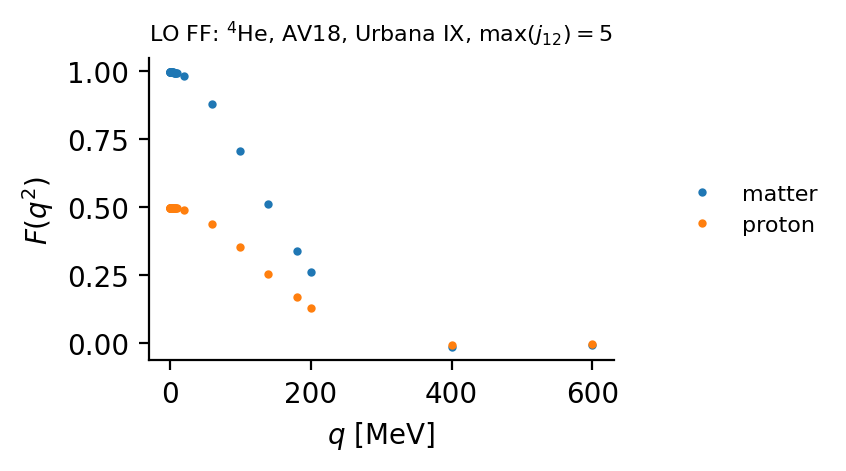

In [14]:
fig, ax = plt.subplots(dpi=200, figsize=(3, 2))

ddf.plot(x="q", y="norm", marker="o", ls="None", ax=ax, ms=2, label="matter")
ddf.plot(x="q", y="norm_p", marker="o", ls="None", ax=ax, ms=2, label="proton")


ax.legend(frameon=False, fontsize=8, bbox_to_anchor=(1.1, 0.5), loc="center left")
ax.set_ylabel("$F(q^2)$")
ax.set_xlabel("$q$ [MeV]")
ax.set_title("LO FF: $^4$He, AV18, Urbana IX, $\max(j_{12}) = 5$", fontsize=8)

sns.despine()
plt.show()